In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import spacy
spacy.require_gpu()
CFG = {'device': 2, 'cpu_count': 4}

In [3]:
import spacy
import ru2e
nlp = ru2e.load_ru2('../../ru2e')

In [4]:
from corus import load_lenta
path = '../../data/lenta-ru-news.csv.gz'
records = load_lenta(path)
record0 = next(records)
record0

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество'
)

In [5]:
nlp.pipeline

[]

In [6]:
import explacy
explacy.print_parse_info(nlp, record0.title)

Dep tree Token       Dep type Lemma      Part of Sp
──────── ─────────── ──────── ────────── ──────────
         Названы              Названы              
         регионы              регион               
         России               россия               
         с                    с                    
                                         SPACE     
         самой                самой                
         высокой              высокий              
         смертностью          смертность           
         от                   от                   
                                         SPACE     
         рака                 рака                 


In [7]:
import pandas
pandas.set_option('max_colwidth', 200)
from tqdm.auto import tqdm as tq

In [8]:
records = load_lenta(path)
# overfitting and underfitting
# splitting the dataset. how many examples to take for a test?
dataset = []
for i, r in tq(enumerate(records), total=25000):
    if not r.topic:
        # есть примеры в датасете, где нет категории
        continue
    dataset.append((r.title, r.topic))
    if len(dataset) >= 25000:
        break
df = pandas.DataFrame(dataset, columns=['title', 'topic'])
print(len(df))
df.head(5)

25000


,title,topic
0,Названы регионы России с самой высокой смертностью от рака,Россия
1,Австрия не представила доказательств вины российских биатлонистов,Спорт
2,Обнаружено самое счастливое место на планете,Путешествия
3,В США раскрыли сумму расходов на расследование «российского дела»,Мир
4,Хакеры рассказали о планах Великобритании заминировать Севастополь,Мир


In [9]:
#train, dev, test
#20000, 2500, 2500 
from sklearn.model_selection import train_test_split
df_train, df_dev = train_test_split(dataset, test_size=2500, random_state=42)
df_train, df_test = train_test_split(df_train, test_size=2500, random_state=42)
print(len(df_train), len(df_dev), len(df_test))
display(df_train[:5])
display(df_dev[:5])

20000 2500 2500


[('В России закрыли чемпионат мира по\xa0футболу', 'Спорт'),
 ('Назначенный Орешкиным неизвестный таджик обрел миссию', 'Экономика'),
 ('В Киеве массово лопнули трубы после подачи горячей воды', 'Бывший СССР'),
 ('Россиянин избежал тюрьмы за\xa0убийство оскорбившей его девушки', 'Россия'),
 ('Умер режиссер «Чегемского детектива» Александр Светлов', 'Культура')]

[('Телеведущей отказали в\xa0работе из-за «недостаточно большой груди»',
  'Интернет и СМИ'),
 ('Шарапова ответила на\xa0отказ Серены Уильямс играть против нее', 'Спорт'),
 ('Bvlgari представил новые вариации на\xa0змеиную тему', 'Ценности'),
 ('Найден новый способ победить особо опасный рак', 'Наука и техника'),
 ('Анестезиолог изнасиловал россиянку под наркозом и\xa0пошел под суд',
  'Силовые структуры')]

In [10]:
classes = sorted(set([_[1] for _ in dataset]))
print(len(classes), 'classes :', classes)

17 classes : ['69-я параллель', 'Бизнес', 'Бывший СССР', 'Дом', 'Из жизни', 'Интернет и СМИ', 'Крым', 'Культпросвет ', 'Культура', 'Мир', 'Наука и техника', 'Путешествия', 'Россия', 'Силовые структуры', 'Спорт', 'Ценности', 'Экономика']


In [11]:
if 'textcat' in nlp.pipe_names:
    nlp.disable_pipes('textcat')
textcat = nlp.create_pipe(
    "textcat", config={"exclusive_classes": True, "architecture": "simple_cnn"}
)
# textcat = nlp.create_pipe(
#     "textcat", config={"exclusive_classes": True}
# )
nlp.add_pipe(textcat)

for c in classes:
    textcat.add_label(c)

nlp.pipeline

[('textcat', <spacy.pipeline.pipes.TextCategorizer at 0x7f3ed9212a58>)]

In [12]:
import random
from spacy.util import minibatch, compounding

In [13]:
from tqdm.auto import tqdm

In [14]:
import re
from pymystem3 import Mystem

_LEMMATIZER = None
_LEMMATIZER_CACHE = {}

def tag_(word):
    global _LEMMATIZER
    if _LEMMATIZER is None:
        _LEMMATIZER = Mystem()
        # _LEMMATIZER = MorphAnalyzer('ru')
    try:
        processed = _LEMMATIZER.analyze(word)[0]
    except Exception:
        # not a word at all
        return word
    if not processed.get('analysis'):
        lemma = word.strip()
    else:
        lemma = processed["analysis"][0]["lex"].lower().strip()
    if word.upper() == word:
        return lemma.upper()
    if word.title() == word:
        return lemma.title()
    return lemma

def tag(word):
    global _LEMMATIZER_CACHE
    if word not in _LEMMATIZER_CACHE:
        _LEMMATIZER_CACHE[word] = tag_(word)
    return _LEMMATIZER_CACHE[word]

def tokenize_re(doc):
    return [tag(x) for x in re.split('(\W+)', doc) if x.strip()]

def lemmatized(x):
    return ' '.join(tokenize_re(x))
lemmatized = lambda x: x
lemmatized('Режим ЧС введут в пострадавшем от химикатов крымском городе. Депутат Рады обвинил Украину в дискриминации крымчан')

'Режим ЧС введут в пострадавшем от химикатов крымском городе. Депутат Рады обвинил Украину в дискриминации крымчан'

In [15]:
from livelossplot import PlotLosses

In [16]:
def evaluate(tokenizer, textcat, df, debug=None):
    docs_iter = tqdm((tokenizer(lemmatized(x[0])) for x in df), total=len(df))
    good = 0
    total = 0
    for doc, x in zip(textcat.pipe(docs_iter), df):
        gold = x[1]
        results = sorted(doc.cats.items(), key=lambda x: -x[1])
        best_label, best_score = results[0]
        if debug and debug in x[0]:
            print('text =', x[0])
            print('score = ', int(best_label == gold), ', gold =', gold, ', predicted =', best_label, ', prob =', best_score)
            print(str(results[:3]).replace('),','),\n'))
        if best_label == gold:
            good += 1
        total += 1
    return {"accuracy": good / total}

if textcat.model is True:
    nlp.begin_training(**CFG)
losses = evaluate(nlp.tokenizer, textcat, df_dev, debug='крым')

text = Депутат Рады обвинил Украину в дискриминации крымчан
score =  0 , gold = Бывший СССР , predicted = 69-я параллель , prob = 0.05882352963089943
[('69-я параллель', 0.05882352963089943),
 ('Бизнес', 0.05882352963089943),
 ('Бывший СССР', 0.05882352963089943)]
text = Режим ЧС введут в пострадавшем от химикатов крымском городе
score =  0 , gold = Россия , predicted = 69-я параллель , prob = 0.05882352963089943
[('69-я параллель', 0.05882352963089943),
 ('Бизнес', 0.05882352963089943),
 ('Бывший СССР', 0.05882352963089943)]



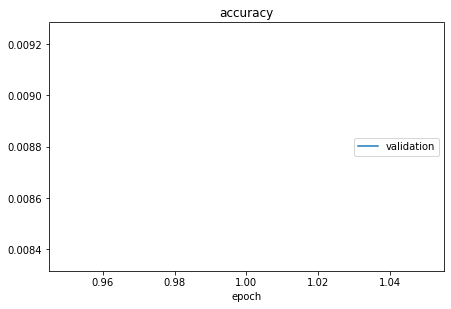

In [17]:
liveloss = PlotLosses(plot_extrema=False)
liveloss.update({'val_'+k:v for k,v in losses.items()})
liveloss.draw()

In [18]:
def make_optimizer():
    from thinc.neural.optimizers import Adam
    from thinc.neural import Model

    # optimizer options. Defaults are changed where commented
    ops = Model.ops
    learn_rate = 0.001
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-9
    L2 = 1e-7
    max_grad_norm = 100.0
    optimizer = Adam(ops, learn_rate, L2=L2, beta1=beta1, beta2=beta2, eps=eps)
    optimizer.max_grad_norm = max_grad_norm
    optimizer.device = ops.device
    return optimizer

In [19]:
import math

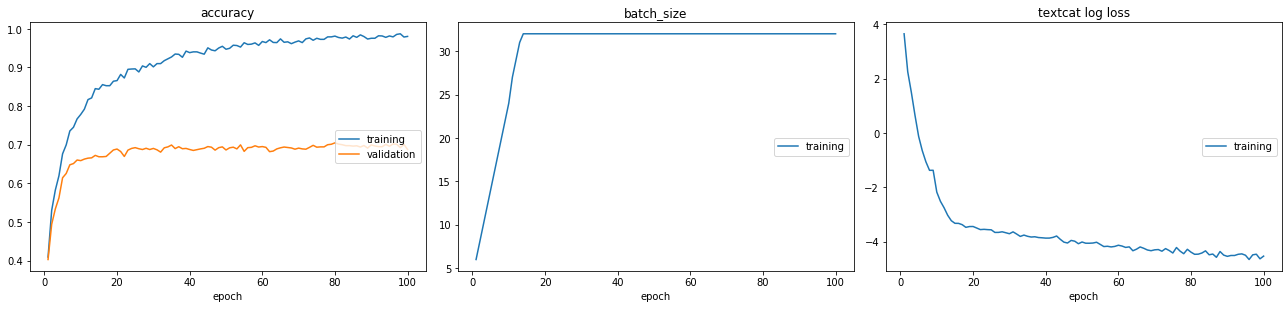

accuracy:
training   (min:    0.409, max:    0.987, cur:    0.980)
validation (min:    0.403, max:    0.705, cur:    0.688)

batch_size:
training   (min:    6.000, max:   32.000, cur:   32.000)

textcat log loss:
training   (min:   -4.652, max:    3.653, cur:   -4.527)


In [20]:
n_iter = 100

liveloss = PlotLosses(skip_first=0, max_cols=3)

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]
with nlp.disable_pipes(*other_pipes):  # only train textcat
    print("Training:", nlp.pipeline)
    optimizer = nlp.resume_training(**CFG)
    #print("{:^5}\t{:^5}".format("LOSS", "ACC"))
    batch_sizes = compounding(4.0, 32.0, 1.0005)
    for i in range(n_iter): #tqdm(range(n_iter)):
        max_batch_size = 0
        losses = {}
        random.shuffle(df_train)
        batches = minibatch(tqdm(df_train[:4000], leave=False), size=batch_sizes)
        for j, batch in enumerate(batches):
            max_batch_size = max(max_batch_size, len(batch))
            #texts, annotations = zip(*batch)
            docs = []
            golds = []
            for text, gold_cat in batch:
                docs.append(lemmatized(text))
                golds.append({'cats': {c: gold_cat==c for c in classes}})
            nlp.update(docs, golds, sgd=optimizer, drop=0.2, losses=losses)
        all_losses = evaluate(nlp.tokenizer, textcat, df_train[-2500:])
        all_losses.update({'batch_size': max_batch_size, 'textcat log loss': math.log(1e-10 + losses['textcat'])})
        val_losses = evaluate(nlp.tokenizer, textcat, df_dev)
        all_losses.update({'val_'+k: v for k,v in val_losses.items()})
        liveloss.update(all_losses)
        liveloss.draw()